## Reward and early detection

In [1]:
%matplotlib inline
import sys
sys.path.append('../')

import tensorflow as tf
import numpy as np
from database.MIMIC_cache_exp import MIMIC_cache_discretized_exp_joint, \
    MIMIC_cache_discretized_joint_exp_independent_measurement
import matplotlib.pyplot as plt

## Settings
- Use val set to determine threshold.
- Then calculate early detection time.
- Then calculate total num of measurements.
- Then calculate the cost for each measurements (proportion to num of actions in train/val)

In [2]:
mimic_cache = MIMIC_cache_discretized_joint_exp_independent_measurement(
    cache_dir='../RL_exp_cache/1012-15mins-48hrs-joint-indep-measurement')
sess = tf.Session()

In [3]:
val_loader = mimic_cache.gen_val_experience(sess, batch_size=100, shuffle=False)

In [4]:
next(iter(val_loader)).keys()

dict_keys(['cur_state', 'next_state', 'gain_per_action', 'prob_gain_per_action', 'prob_gain_std_per_action', 'cur_action', 'next_action', 'labels', 'patient_inds', 'the_steps', 'total_steps', 'gain_joint', 'prob_joint', 'prob_joint_std', 'cur_prob_joint', 'cur_prob_joint_std'])

In [6]:
all_probs = []
all_labels = []
for data_dict in val_loader:
    all_probs.append(data_dict['prob_joint'])
    all_labels.append(data_dict['labels'])
all_probs = np.concatenate(all_probs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

## AUPR

Text(0.5,1,'2-class Precision-Recall curve: AP=0.30')

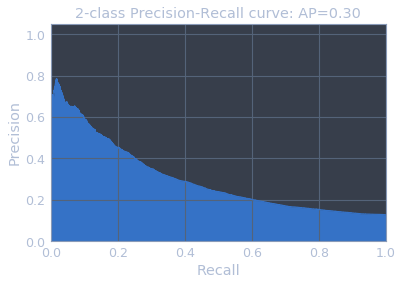

In [7]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.utils.fixes import signature

average_precision = average_precision_score(all_labels, all_probs)

precision, recall, _ = precision_recall_curve(all_labels, all_probs)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', where='post')
plt.fill_between(recall, precision, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

## AUROC

In [8]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(all_labels, all_probs, drop_intermediate=True)

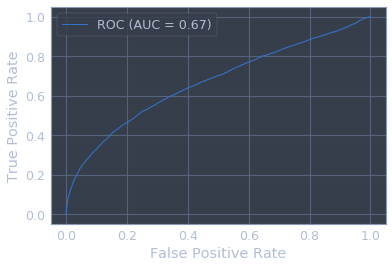

In [9]:
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1,
         label='ROC (AUC = %0.2f)' % (roc_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

In [10]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(all_labels, all_probs, drop_intermediate=True)
for idx in range(len(fpr)):
    if fpr[idx] > 0.5:
        break

In [12]:
fpr[idx], tpr[idx], thresholds[idx]

(0.50027474338967404, 0.70177283653846156, 0.12025802)

## threshold is around 0.12

In [13]:
def reward_func(actions, gain, labels):
    """
    Generate reward based on the information gain by independently estiamte the each measurement in curr state using
    0616-15mins-48hrs-splitt
    """
    # param_1 for general gain improvement
    information_gain = args.reward_param_1 * gain
    # Increase param_4 for the positive case of info gain
    information_gain = args.reward_param_4 * information_gain * labels[:, None] \
                       + (1 - labels[:, None]) * information_gain

    # Increase param_3 for action cost
    action_costs = args.reward_param_3 * actions[:, :-1] if not hasattr(args, 'per_action_cost') \
        else args.reward_param_3 * actions[:, :-1] * args.per_action_cost

    if hasattr(args, 'reward_param_1_cap'):
        information_gain = np.clip(information_gain,
                                   a_min=-abs(args.reward_param_1_cap),
                                   a_max=abs(args.reward_param_1_cap))

    rewards = information_gain - action_costs.sum(axis=-1)
    return rewards

In [14]:
from types import SimpleNamespace
threshold = 0.12
gamma = 0.99
args = SimpleNamespace(reward_param_1 = 1., reward_param_3 = 0.01, 
                       reward_param_4 = 1., reward_param_1_cap = 100)
args.per_action_cost = 1.

In [ ]:
test_loader = mimic_cache.gen_test_experience(sess, batch_size=1, shuffle=False)

test_result = []
for data_dict in test_loader:
    processed_dict = {k[0] for k in data_dict}
    test_result.append(processed_dict)

In [ ]:
test_pd = pd.DataFrame(test_result)

In [ ]:
test_pd.head()

In [17]:
test_loader = mimic_cache.gen_test_experience(sess, batch_size=1, shuffle=False)

# Patient idx map to the 
early_steps = {}
rewards = {}
patients_idx_died = set()
num_cur_action = {}
num_corrects = {}
total_steps = {}
gain_joint = {}
for data_dict in test_loader:
#     data_dict['gain_joint'][data_dict['gain_joint'] < 0] = 0
    
    p_idx = data_dict['patient_inds'][0]
    
    val = num_corrects.get(p_idx, 0)
    num_corrects[p_idx] = val + int(data_dict['labels'][0] == int(data_dict['prob_joint'][0] > threshold))
    
    total_steps[p_idx] = data_dict['total_steps'][0]
    
    if data_dict['labels'][0] == 0:
        continue
    
    patients_idx_died.add(p_idx)
    
    the_gain_joint = gain_joint.get(p_idx, 0)
    gain_joint[p_idx] = the_gain_joint + data_dict['gain_joint'][0]
    
    # It classifies as true! Means early detection!
    if data_dict['prob_joint'][0] > threshold:
        stored_early_step = early_steps.get(p_idx, -1)
        early_step = data_dict['total_steps'][0] - data_dict['the_steps'][0] - 1
        if stored_early_step < early_step:
            early_steps[p_idx] = early_step
    
    # cal cur_action
    na = num_cur_action.get(p_idx, 0)
    num_cur_action[p_idx] = na + data_dict['cur_action'][0, :-1].sum()
    
    # cal reward
    reward = rewards.get(p_idx, 0)
    rewards[p_idx] = reward + \
        gamma ** data_dict['the_steps'][0] * \
        reward_func(data_dict['cur_action'], data_dict['gain_joint'], data_dict['labels'])[0, 0]
    

In [18]:
len(early_steps), len(patients_idx_died), len(early_steps) / len(patients_idx_died)

(487, 549, 0.8870673952641166)

In [19]:
the_num_cur_action = [num_cur_action[p_idx] for p_idx in patients_idx_died]
the_rewards = [rewards[p_idx] for p_idx in patients_idx_died]
the_early_steps = [early_steps.get(p_idx, -1) for p_idx in patients_idx_died]
accs = [num_corrects[p_idx] / total_steps[p_idx]  for p_idx in patients_idx_died]
the_gain_joint = [gain_joint[p_idx] for p_idx in patients_idx_died]

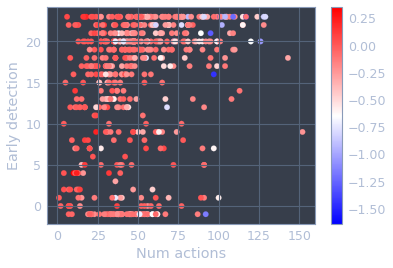

In [20]:
plt.scatter(the_num_cur_action, the_early_steps, c=the_rewards, cmap='bwr')
# plt.xlabel('Ratio between reward and costs (num of actions)')
plt.ylabel('Early detection')
plt.xlabel('Num actions')
plt.colorbar()

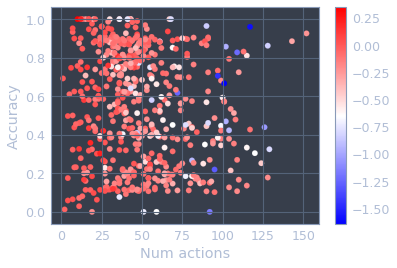

In [21]:
the_num_cur_action = np.array(the_num_cur_action)
accs = np.array(accs)
the_rewards = np.array(the_rewards)

plt.scatter(the_num_cur_action, accs, c=the_rewards, cmap='bwr')
# plt.xlabel('Ratio between reward and costs (num of actions)')
plt.ylabel('Accuracy')
plt.xlabel('Num actions')
plt.colorbar()

/home/zzzace2000/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


(0, 1.0)

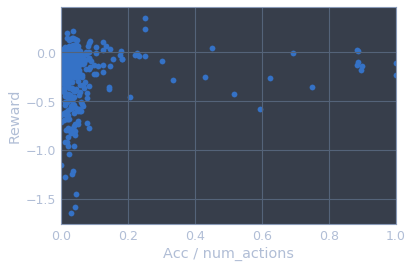

In [22]:
# plt.scatter(the_early_steps, accs, c=the_rewards, cmap='bwr')
plt.scatter(np.array(accs) / the_early_steps, 
            the_rewards)
# plt.xlim(0., 0.15)
# plt.xlabel('Ratio between reward and costs (num of actions)')
plt.ylabel('Reward')
plt.xlabel('Acc / num_actions')
plt.xlim(0, 1.)
# plt.colorbar()

Text(0.5,0,'Acc')

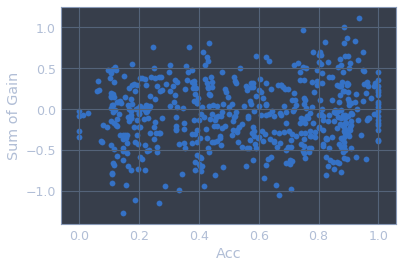

In [23]:
# plt.scatter(the_actions, accs, c=the_rewards, cmap='bwr')
plt.scatter(np.array(accs), 
            the_gain_joint)
# plt.xlim(0., 0.2)
# plt.xlabel('Ratio between reward and costs (num of actions)')
plt.ylabel('Sum of Gain')
plt.xlabel('Acc')
# plt.colorbar()

Text(0.5,0,'Early steps')

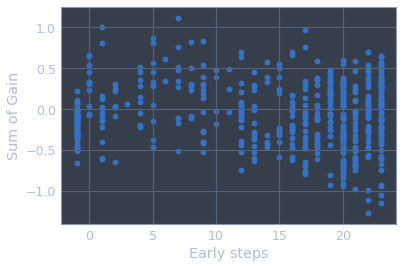

In [24]:
# plt.scatter(the_actions, accs, c=the_rewards, cmap='bwr')
plt.scatter(the_early_steps, 
            the_gain_joint)
# plt.xlim(0., 0.2)
# plt.xlabel('Ratio between reward and costs (num of actions)')
plt.ylabel('Sum of Gain')
plt.xlabel('Early steps')
# plt.colorbar()

## Conclusions
- Early detection is different from reward design.
- Use a more different metric: like accuracy of classifiers among all the time steps?
    - But why does it make sense?

## Plot probability and info gain per patient trajectory

In [26]:
import pandas as pd
test_loader = mimic_cache.gen_test_experience(sess, batch_size=1, shuffle=False)

# Patient idx map to the 
result = []
for data_dict in test_loader:
    p_idx = data_dict['patient_inds'][0]
    
    gain_joint = data_dict['gain_joint'][0]
    prob_joint = data_dict['prob_joint'][0]
    
    rel_end = -(data_dict['total_steps'][0] - data_dict['the_steps'][0] - 1)
    result.append({'gain_joint': gain_joint, 'rel_end': rel_end, 'p_idx': p_idx, 'prob_joint': prob_joint})

In [27]:
result_pd = pd.DataFrame(result)

In [28]:
result_pd.head()

,gain_joint,p_idx,prob_joint,rel_end
0,0.02432,18,0.100005,-174
1,0.00000,18,0.102268,-173
2,0.00000,18,0.103374,-172
3,0.00000,18,0.111839,-171
4,0.00547,18,0.104705,-170


In [29]:
filter_pd = result_pd.loc[(result_pd['p_idx'] > 200) & (result_pd['p_idx'] < 300)]
filter_pd['subject'] = 0

/home/zzzace2000/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


/home/zzzace2000/anaconda2/envs/py36/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


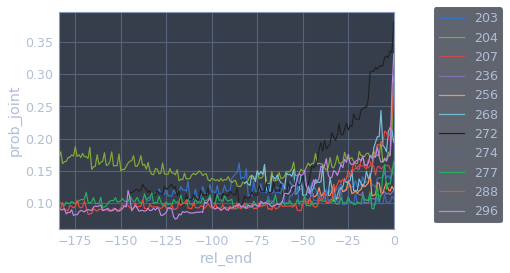

In [30]:
import seaborn as sns
fig, ax = plt.subplots()

sns.tsplot(filter_pd, time='rel_end', condition='p_idx', value='prob_joint', ax=ax, unit='subject')
ax.legend(bbox_to_anchor=(1.1, 1.05))

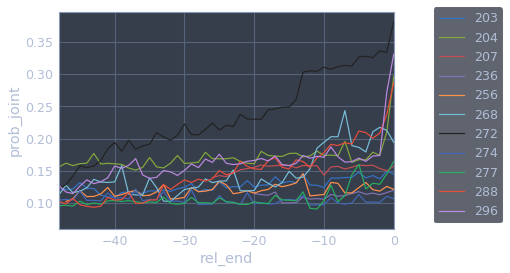

In [31]:
ax.set_xlim(-48, 0)
fig

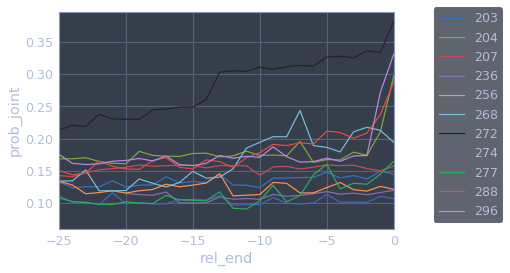

In [32]:
ax.set_xlim(-25, 0)
fig

/home/zzzace2000/anaconda2/envs/py36/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


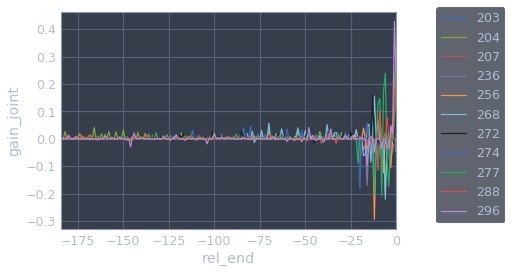

In [33]:
import seaborn as sns
fig, ax = plt.subplots()

sns.tsplot(filter_pd, time='rel_end', condition='p_idx', value='gain_joint', ax=ax, unit='subject')
ax.legend(bbox_to_anchor=(1.1, 1.05))

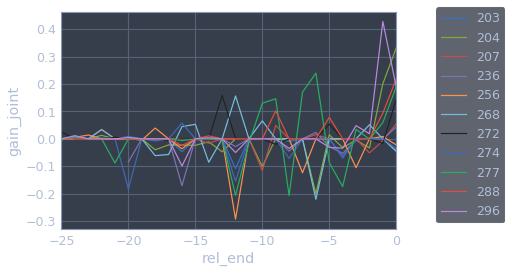

In [34]:
ax.set_xlim(-25, 0)
fig